# Tidal Analysis
## Group Members: Burleigh Charlton
This notebook uses tidal measurements taken in Santa Cruz, California between in January and February 2022 and fits an oscilatorry function to it the data. Subsequent minor data analysis is done on the fit and a tsunami outlier is considered

## Import Libraries and set plot style

In [402]:
from scipy import optimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [403]:
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 100

## Import Data and Prep for analysis

In [404]:
colnames=['day', 'time', 'tide'] 
df = pd.read_fwf(r'ASTR19_S22_group_project_data.txt', header=None, skiprows=(0,1,2), names=colnames)
df.head()

,day,time,tide
0,1,8:07,6.57
1,1,15:37,-0.39
2,2,8:55,5.38
3,2,16:25,-1.74
4,3,9:45,5.26


### Convert Conventional Time to Float

In [405]:
def timeto_min(ts):
  '''
  takes a string representing the tiume and returns minutes from start of day
  '''
  minutes = sum(int(x) * 60 ** i for i, x in enumerate(reversed(ts.split(':'))))
  return minutes

In [406]:
h= df['day']
h = 24 * 60 * h
ti= df['time']
ti = np.array(list(map(timeto_min, ti)))

In [407]:
#After looking at the results created by minutes I believe that hours may be a more suitable metric
x = h+ti
x = x/60
#x now represents hours

Text(0.5, 1.0, 'Time In Hours')

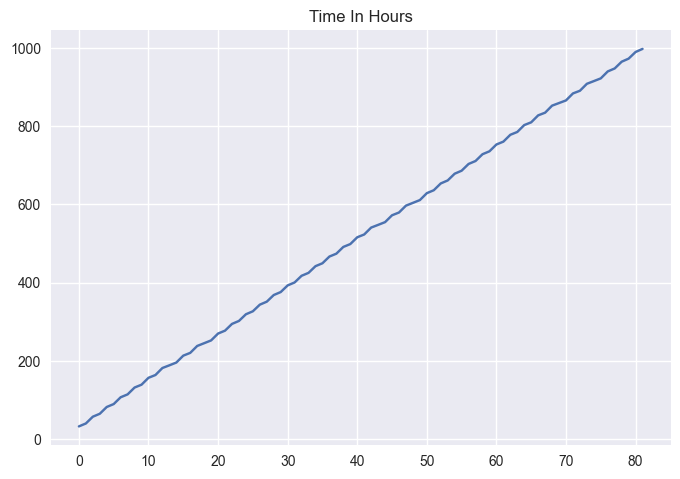

In [408]:
#Check that the data is monotonically increasing via a plot
plt.plot(x)
plt.title('Time In Hours')

In [409]:
#and now we store it in the dataframe
df['hours'] = x

In [410]:
max(x)

997.2333333333333

In [411]:
df['y_error'] = np.full(len(df['tide']), .25)

### Initial Plot of Data

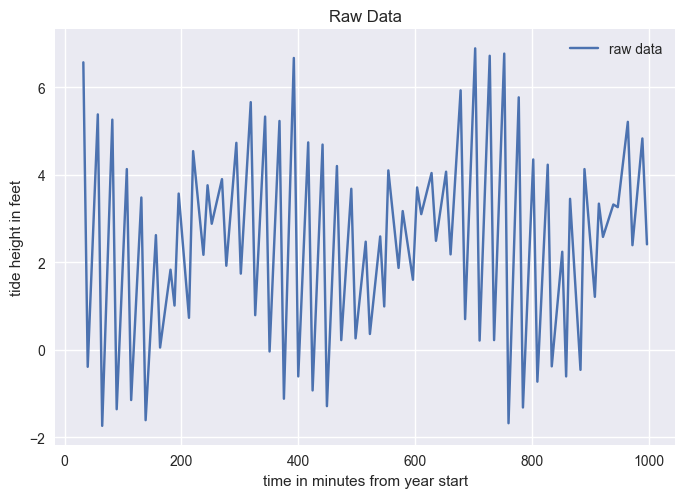

In [412]:
plt.plot( df['hours'], df['tide'], label = 'raw data')
plt.xlabel('time in minutes from year start')
plt.ylabel('tide height in feet')
plt.title('Raw Data')
plt.legend()
plt.savefig('data.png')

## Curve Fitting

In [413]:
#here we create an interpolated set of time data to plot our model against
hours_i = np.linspace(1,1000,10000)

This objecive function is of the form $(a_1 \cdot \sin(f_1 \cdot x + p_1 ) + a_2\cdot \sin(f_2 \cdot x +p_2) + h_{offset}) \cdot a_o(\sin(f_o \cdot x)  + p_o)  + v_{offset}$ where $a$s are amplitudes, $p$s are phases, and $f$s are freqiencies.  
This is designed such that I sum two freqencies with around 2 week and 4 week periods to represent the oscillating amplitude, on the 24 hour tidal changes. 
This is reflected in my inital guesses

In [414]:
##now lets try and make it have a sinusoidal wave as an amplitude to get intra day variation
#(a1 * sin(f1 * x + p1 ) + a2* sin(f2 * x +p2) + a3* sin(f3 * x  + p3)) * (sin(fo * x)  + po) + vertical_offsetmean
def three_sine(x, a1, f1,p1, a2, f2,p2, fo,po,v):
  return  (a1 * np.sin(f1*x + p1) + a2* np.sin(f2*x + p2)) * (np.sin(fo*x + po)) + v
params, paramscov = optimize.curve_fit(three_sine,x, df['tide'], p0=[1,(2*np.pi/730),1,1,(2*np.pi/336),1,(2*np.pi/24),2.22,2], sigma=df['y_error'])#p0=[1,(2*np.pi/730),1,1,(2*np.pi/336),1,(2*np.pi/24),2.22,2]

a1_fit = params[0]
f1_fit = params[1]
p1_fit = params[2]
a2_fit = params[3]
f2_fit = params[4]
p2_fit = params[5]
fo_fit = params[6]
po_fit = params[7]
v_fit = params[8]

print(params)
omodel_fit =  ( a1_fit * np.sin(f1_fit*x + p1_fit) +  a2_fit * np.sin(f2_fit*x + p2_fit)) * (np.sin(fo_fit*x + po_fit)) + v_fit
df['omodel_fit'] = omodel_fit
omodel_i_fit = ( a1_fit * np.sin(f1_fit*hours_i + p1_fit) +  a2_fit * np.sin(f2_fit*hours_i + p2_fit)) * (np.sin(fo_fit*hours_i + po_fit)) + v_fit

[-3.84216851  0.00877312  1.01027905  0.28144776  0.01896276  3.4153267
  0.27069422 -3.86422092  2.51305635]


In [415]:
#with another amplitude parameter
##now lets try and make it have a sinusoidal wave as an amplitude to get intra day variation
#(a1 * sin(f1 * x + p1 ) + a2* sin(f2 * x +p2)  * (sin(fo * x)  + po) + vertical_offsetmean
def three_sine(x, a1, f1,p1, a2, f2,p2, hoff,ao,fo,po,v):
  return  (a1 * np.sin(f1*x + p1) + a2* np.sin(f2*x + p2) + hoff) * ao *(np.sin(fo*x + po)) + v
params, paramscov = optimize.curve_fit(three_sine,x, df['tide'], p0=[1.5,(2*np.pi/730),4,6,(2*np.pi/336),2,1,3,(2*np.pi/24),3.22,2], sigma=df['y_error'])#p0=[1,(2*np.pi/730),1,1,(2*np.pi/336),1,(2*np.pi/24),2.22,2]

a1_fit   = params[0]
f1_fit   = params[ 1]
p1_fit   = params[2 ]
a2_fit   = params[ 3]
f2_fit   = params[4 ]
p2_fit   = params[5]
hoff_fit = params[6 ]
ao_fit   = params[ 7]
fo_fit   = params[8]
po_fit   = params[ 9]
v_fit    = params[10]

print(params)
omodel_fit =  ( a1_fit * np.sin(f1_fit*x + p1_fit) +  a2_fit * np.sin(f2_fit*x + p2_fit) + hoff_fit) * ao_fit* (np.sin(fo_fit*x + po_fit)) + v_fit
df['omodel_fit'] = omodel_fit
omodel_i_fit = ( a1_fit * np.sin(f1_fit*hours_i + p1_fit) +  a2_fit * np.sin(f2_fit*hours_i + p2_fit) + hoff_fit) *ao_fit* (np.sin(fo_fit*hours_i + po_fit)) + v_fit

[-1.17496961e+00  8.98312748e-03  3.44596958e+00 -4.83883170e+00
  1.82053633e-02 -2.74387259e+00  9.51221371e+00 -2.98648936e-01
  2.61706080e-01  3.12305402e+00  2.58287691e+00]


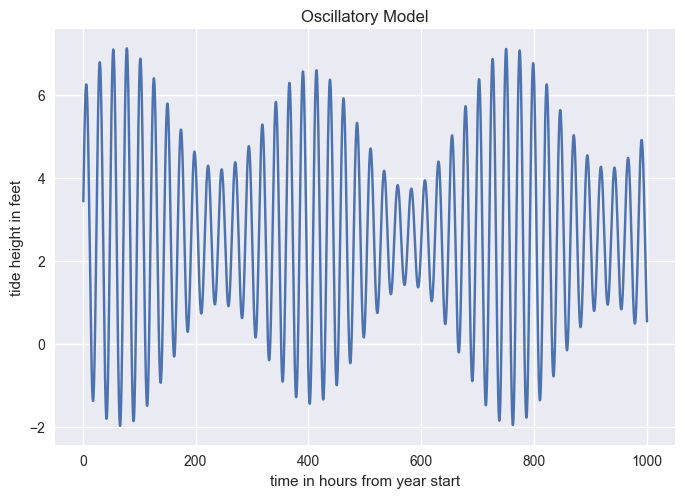

In [416]:
#Here we plot the model against our smooth representative time space
plt.plot(hours_i, omodel_i_fit)
plt.title('Oscillatory Model')
plt.xlabel('time in hours from year start')
plt.ylabel('tide height in feet')
plt.savefig('fit.png')

## Fit Plot against Data

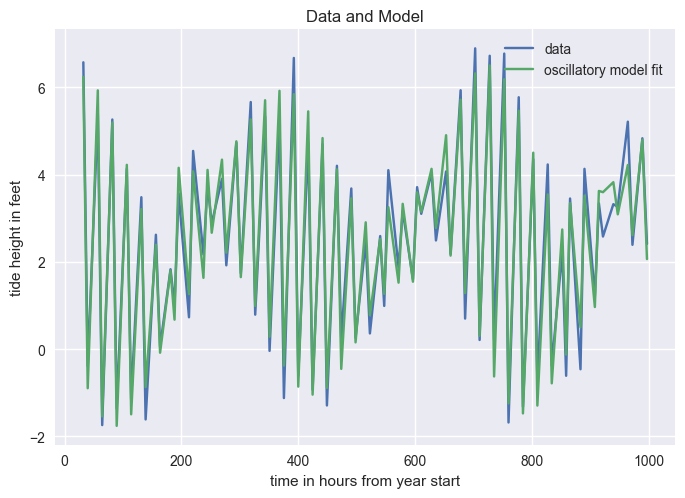

In [417]:
#f = plt.figure(figsize = (7,7))
#plt.errorbar(df['hours'],df['tide'], yerr = df['y_error'], fmt = 'o', label = 'data with error')
plt.plot(df['hours'],df['tide'], label = 'data')
plt.plot(df['hours'],omodel_fit, label = 'oscillatory model fit')
#plt.plot(x,tide_fit, label = 'tide_fit')
plt.xlabel('time in hours from year start')
plt.ylabel('tide height in feet')
plt.legend(loc = 'upper right' )
plt.title('Data and Model')
plt.savefig('fitvdata.png')

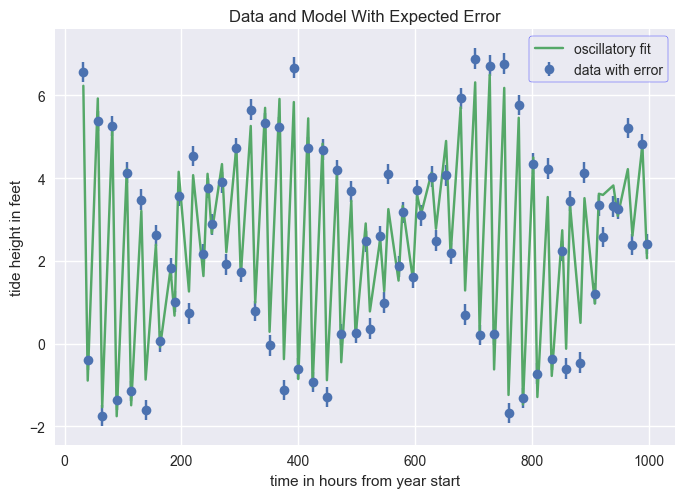

In [418]:
#f = plt.figure(figsize = (7,7))
plt.errorbar(df['hours'],df['tide'], yerr = df['y_error'], fmt = 'o', label = 'data with error')
#plt.plot(df['hours'],df['tide'], label = 'data')
plt.plot(df['hours'],omodel_fit, label = 'oscillatory fit')
#plt.plot(x,tide_fit, label = 'tide_fit')
plt.xlabel('time in hours from year start')
plt.ylabel('tide height in feet')
leg = plt.legend(loc = 'upper right', frameon = True )
leg.get_frame().set_edgecolor('b')
plt.title('Data and Model With Expected Error')
plt.savefig('fitvdata.png')

## Residual Analysis

In [419]:
df['residuals'] = df['tide'] - df['omodel_fit']

In [420]:
df['residuals'].describe()

count    82.000000
mean     -0.000002
std       0.450429
min      -1.015398
25%      -0.340516
50%       0.060604
75%       0.328240
max       0.991348
Name: residuals, dtype: float64

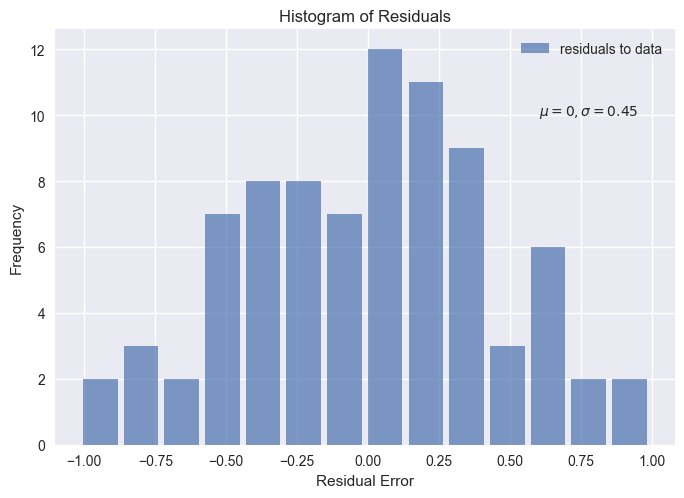

In [421]:
plt.hist(df['residuals'], bins = 14, label = 'residuals to data', alpha=0.7, rwidth=0.85)
plt.xlabel('Residual Error')
plt.ylabel('Frequency')
plt.text(.6, 10, r'$\mu=0, \sigma=0.45$')
plt.title('Histogram of Residuals')
plt.legend()
plt.savefig('ResidualHist.png')

In my fit the residuals are very centered around 0 indicating that the the offset is well calibrated, but there are signfigant errors in the actual fit. With a standard deviation of .45 we are worse off than the expected inaccuracies in our data. The maximum residual found was 1.  



In [422]:
#df.append({'residuals': 2}, ignore_index=True)

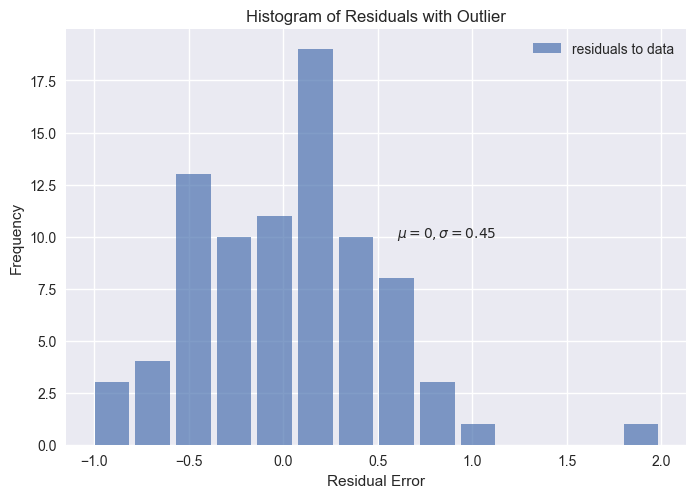

In [423]:
plt.hist(pd.concat([df['residuals'], pd.Series([2])]), bins = 14, label = 'residuals to data', alpha=0.7, rwidth=0.85)
plt.xlabel('Residual Error')
plt.ylabel('Frequency')
#plt.text(.6, 10, r'$\mu=0, \sigma=0.45$')
plt.title('Histogram of Residuals with Outlier')
plt.legend()
plt.savefig('ResidualHist_outlier.png')

To calculate how unlikely this event is we can check the z score via $\frac{x - \mu}{\sigma}$

In [394]:
(2 - df['residuals'].mean())/df['residuals'].std()

4.440214870272089

## Moving average analyis
Now depreciated

In [46]:
#moving average of data
pd.options.mode.chained_assignment = None
df['tideavg'] = df['tide'].rolling(2).mean()
first2mean = np.mean([df['tideavg'][1], df['tideavg'][2]])
df['tideavg'][0] = first2mean

In [82]:
df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

,day,time,tide,tideavg
0,1,8:07,6.57,2.7925
1,1,15:37,-0.39,3.0900
2,2,8:55,5.38,2.4950
3,2,16:25,-1.74,1.8200
4,3,9:45,5.26,1.7600
...,...,...,...,...
77,39,11:15,3.26,3.2900
78,40,4:29,5.21,4.2350
79,40,12:22,2.39,3.8000
80,41,5:21,4.83,3.6100


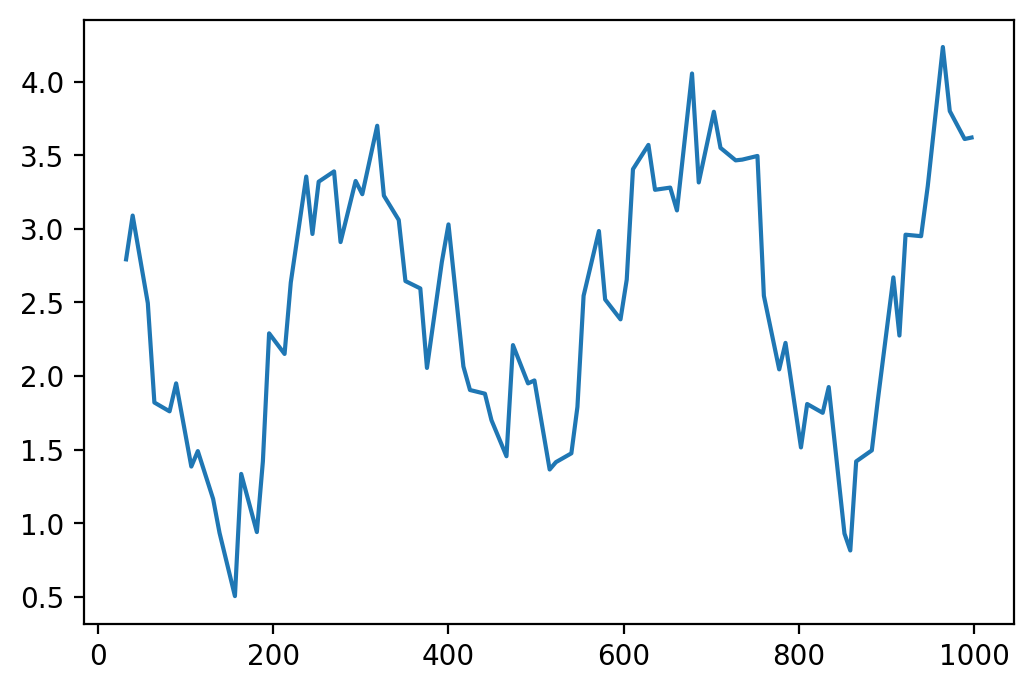

In [83]:
plt.plot(x,df['tideavg'])

In [84]:
#code taken from class

def f_line(x,a,b,c,d):
  return a * np.sin(b*x + c) + d

params, paramscov = optimize.curve_fit(f_line, x, df['tideavg'], sigma=y_error, p0 = [1,.02,1000,2] )

a_fit = params[0]
b_fit = params[1]
c_fit = params[2]
d_fit = params[3]


print(a_fit, b_fit, c_fit, d_fit)

1.1160472891040827 0.017909148867226592 1001.2677334180995 2.533212698773293


In [85]:
avg_fit = a_fit * np.sin(b_fit * x + c_fit) + d_fit
#y_fit = 1 * np.sin(.00035 * x + 1000) + 2

In [86]:
params, paramscov = optimize.curve_fit(f_line, x, df['tide'], sigma=y_error, p0 = [1,.02,1000,2] )

a_fit = params[0]
b_fit = params[1]
c_fit = params[2]
d_fit = params[3]


tide_fit = a_fit * np.sin(b_fit * x + c_fit) + d_fit
df['fit'] = tide_fit

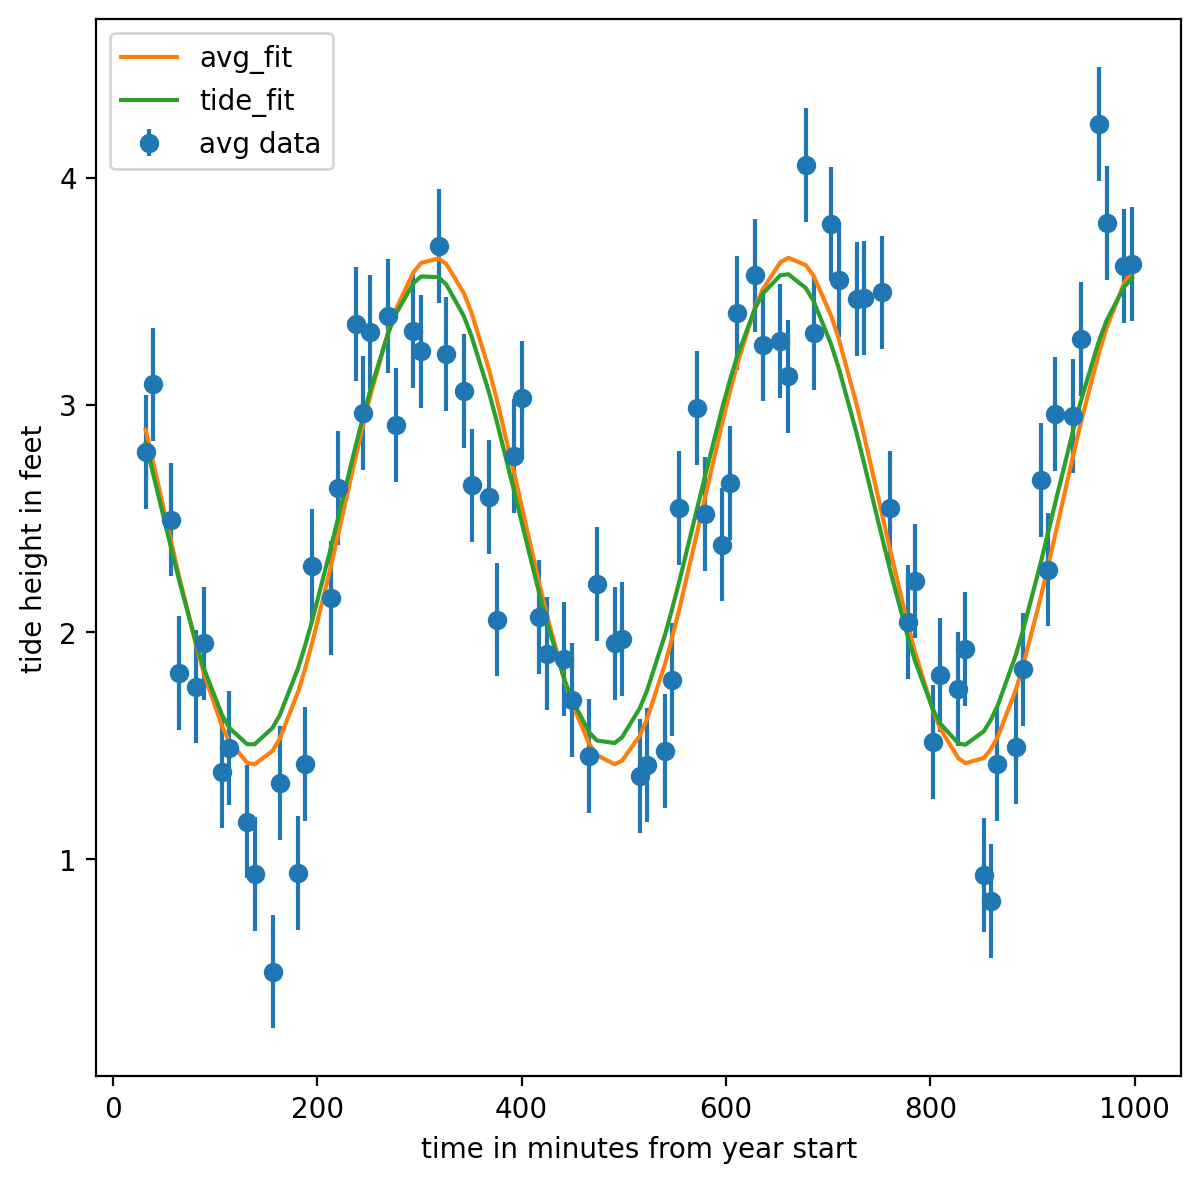

In [87]:
f = plt.figure(figsize = (7,7))
plt.errorbar(x,df['tideavg'], yerr = y_error, fmt = 'o', label = 'avg data')
plt.plot(x,avg_fit, label = 'avg_fit')
plt.plot(x,tide_fit, label = 'tide_fit')
plt.xlabel('time in minutes from year start')
plt.ylabel('tide height in feet')
plt.legend()

In [88]:
df['residuals'] = df['tide'] - df['fit']
df['residuals_avg'] = df['tideavg'] - df['fit']

In [89]:
df['residuals']

0     3.739987
1    -3.083535
2     3.007738
3    -3.976194
4     3.313194
        ...   
77    0.242707
78    1.934898
79   -0.980896
80    1.311555
81   -1.146622
Name: residuals, Length: 82, dtype: float64

## forier analysis

In [38]:

    
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 43                 # number of harmonics in model according to NOAA
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = np.fft.fft(x_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies
    indexes = range(n)
    # sort indexes by frequency, lower -> higher
    indexes = list(indexes)
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t
    
#    x = np.array([669, 592, 664, 1005, 699, 401, 646, 472, 598, 681, 1126, 1260, 562, 491, 714, 530, 521, 687, 776, 802, 499, 536, 871, 801, 965, 768, 381, 497, 458, 699, 549, 427, 358, 219, 635, 756, 775, 969, 598, 630, 649, 722, 835, 812, 724, 966, 778, 584, 697, 737, 777, 1059, 1218, 848, 713, 884, 879, 1056, 1273, 1848, 780, 1206, 1404, 1444, 1412, 1493, 1576, 1178, 836, 1087, 1101, 1082, 775, 698, 620, 651, 731, 906, 958, 1039, 1105, 620, 576, 707, 888, 1052, 1072, 1357, 768, 986, 816, 889, 973, 983, 1351, 1266, 1053, 1879, 2085, 2419, 1880, 2045, 2212, 1491, 1378, 1524, 1231, 1577, 2459, 1848, 1506, 1589, 1386, 1111, 1180, 1075, 1595, 1309, 2092, 1846, 2321, 2036, 3587, 1637, 1416, 1432, 1110, 1135, 1233, 1439, 894, 628, 967, 1176, 1069, 1193, 1771, 1199, 888, 1155, 1254, 1403, 1502, 1692, 1187, 1110, 1382, 1808, 2039, 1810, 1819, 1408, 803, 1568, 1227, 1270, 1268, 1535, 873, 1006, 1328, 1733, 1352, 1906, 2029, 1734, 1314, 1810, 1540, 1958, 1420, 1530, 1126, 721, 771, 874, 997, 1186, 1415, 973, 1146, 1147, 1079, 3854, 3407, 2257, 1200, 734, 1051, 1030, 1370, 2422, 1531, 1062, 530, 1030, 1061, 1249, 2080, 2251, 1190, 756, 1161, 1053, 1063, 932, 1604, 1130, 744, 930, 948, 1107, 1161, 1194, 1366, 1155, 785, 602, 903, 1142, 1410, 1256, 742, 985, 1037, 1067, 1196, 1412, 1127, 779, 911, 989, 946, 888, 1349, 1124, 761, 994, 1068, 971, 1157, 1558, 1223, 782, 2790, 1835, 1444, 1098, 1399, 1255, 950, 1110, 1345, 1224, 1092, 1446, 1210, 1122, 1259, 1181, 1035, 1325, 1481, 1278, 769, 911, 876, 877, 950, 1383, 980, 705, 888, 877, 638, 1065, 1142, 1090, 1316, 1270, 1048, 1256, 1009, 1175, 1176, 870, 856, 860])
#    n_predict = 100
#    extrapolation = fourierExtrapolation(x, n_predict)
#    pl.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
#    pl.plot(np.arange(0, x.size), x, 'b', label = 'x', linewidth = 3)
#    pl.legend()
#    pl.show()

In [39]:
mytides = df['tide']
n_predict = 100
extrapolation = fourierExtrapolation(mytides, n_predict)
xnew = fourierExtrapolation(x, n_predict)
len(xnew)

182

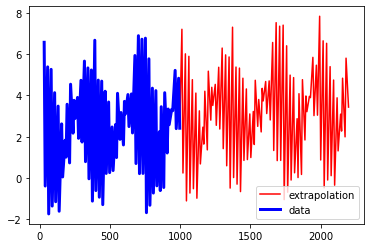

In [40]:
pl.plot(xnew, extrapolation, 'r', label = 'extrapolation')
pl.plot(x, mytides, 'b', label = 'data', linewidth = 3)
pl.legend()
pl.show()

In [41]:
df['hours'] = x

In [42]:
newdf = df.drop(['day', 'time', 'tideavg', 'fit', 'residuals', 'residuals_avg'], axis=1)

In [43]:
newdf.to_csv('tidedata.txt', encoding='utf-8', index=False)

In [79]:
from scipy.stats import ttest_ind
x0=[ 1.61440259,1.67138762,-0.01637776, 0.83468138, 1.10434472,1.51214375,1.81918826, 0.64452334,2.21594525, 1.6284409 ]
x1=[2.05921024, 1.19243816, 2.98865825, 1.78041892, 0.65840815, 2.39363351, 2.34263727, 1.89973928, 2.90954834, 2.8325926 ]
ttest_ind(x0, x1, equal_var = False)

Ttest_indResult(statistic=-2.5265897552237195, pvalue=0.021308927949350097)

0.9282524035870352

9.997278386632368

In [38]:
import numpy as np
w0 = 0
w1 = -0.75
w2 = 0.9


In [42]:
xs = (.1*(  (1- w1*1 -w2*2)*np.array([1,2])  +  (6- w1*(-2)-w2*5)*np.array([-2,5])+(1- w1*0 -w2*1)*np.array([0,1]) ))

In [43]:
warr = np.array([w1,w2])

In [44]:
warr + gradstep

array([-0.755,  0.9  ])

In [37]:
[4,5] ** 5

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

In [4]:
(1- w1*1 -w2*2)**2 

1.0

In [12]:
(6- w1*(-2)-w2*5)

5.5

In [6]:
(1- w1*0 -w2*1)**2

0.25

In [56]:
def gpfun(w1,w2):
    return .5*((1- w1*1 -w2*2)**2  +(6- w1*(-2)-w2*5)**2+(1- w1*0 -w2*1)**2 )

In [30]:
import scipy.optimize as optimize
initial_guess = [1, 1]
result = optimize.minimize(gpfun, initial_guess)
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

[-0.76744189  0.89534882]


In [65]:
w0 = np.linspace(-30,30,100)
w1 = np.linspace(-30,30,100)
w2 = np.linspace(-30,30,100)

In [48]:
xs =.5*((1- w0 * 1 -w1*1 -w2*2)**2  +(6- w0 * 1 - w1*(-2)-w2*5)**2+(1-w0 * 1 - w1*0 -w2*1)**2 )

In [49]:
ys = .5*((1- w0 * 1 -w1*1 -w2*2)**2  +(6-w0 * 1 - w1*(-2)-w2*5)**2+(1-w0 * 1 - w1*0 -w2*1)**2 )

In [48]:
#(a1 * sin(f1 * x + p1 ) + a2* sin(f2 * x +p2) + a3* sin(f3 * x  + p3)) * (sin(fo * x)  + po) + vertical_offsetmean
def three_sine(x, a1, f1,p1, a2, f2,p2, a3, f3,p3, fo,po,v):
  return  (a1 * np.sin(f1*x + p1) + a2* np.sin(f2*x + p2) + a3* np.sin(f3*x + p3)) * (np.sin(fo*x + po)) + v
params, paramscov = optimize.curve_fit(three_sine,df['time'], df['tide'] , p0=[1,(2*np.pi/730),1,1,(2*np.pi/336),1,(2*np.pi/1000),2.22, 1,(2*np.pi/24),2.22,2,])#sigma=y_error, p0=[2,.4,0,1,0,1,.01,2.22,2.5] p0=[2,.4,1,16,1,1,1,2.22,2.5] 

a1_fit = params[0]
f1_fit = params[1]
p1_fit = params[2]
a2_fit = params[3]
f2_fit = params[4]
p2_fit = params[5]
a3_fit = params[6]
f3_fit = params[7]
p3_fit = params[8]
fo_fit = params[9]
po_fit = params[10]
v_fit = params[11]

print(params)
sumsine_fit = ( a1_fit * np.sin(f1_fit*x + p1_fit) +  a2_fit * np.sin(f2_fit*x + p2_fit) + a3_fit * np.sin(f3_fit*x + p3_fit)) * (np.sin(fo_fit*x + po_fit)) + v_fit
new_sumsine_fit = ( a1_fit * np.sin(f1_fit*fittime + p1_fit) +  a2_fit * np.sin(f2_fit*fittime + p2_fit) + a3_fit * np.sin(f3_fit*fittime + p3_fit)) * (np.sin(fo_fit*fittime + po_fit)) + v_fit

TypeError: can't multiply sequence by non-int of type 'float'

In [50]:
zs = .5*((1-w0 * 1 - w1*1 -w2*2)**2  +(6-w0 * 1 - w1*(-2)-w2*5)**2+(1- w0 * 1 -w1*0 -w2*1)**2 )

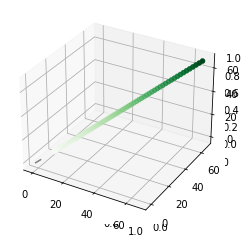

In [54]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline =w0
xline = w1
yline = w2
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = zs
xdata = xs
ydata = ys
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

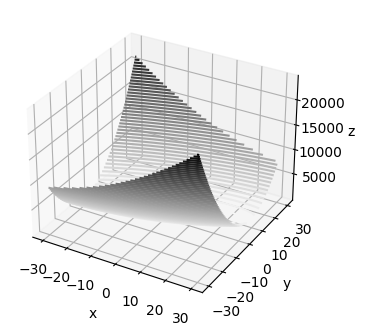

In [68]:
X, Y = np.meshgrid(w1, w2)
Z = gpfun(X, Y)
fig = plt.figure()
plt.rcParams['figure.dpi'] = 200
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [113]:
plt.rcParams['figure.dpi'] = 100

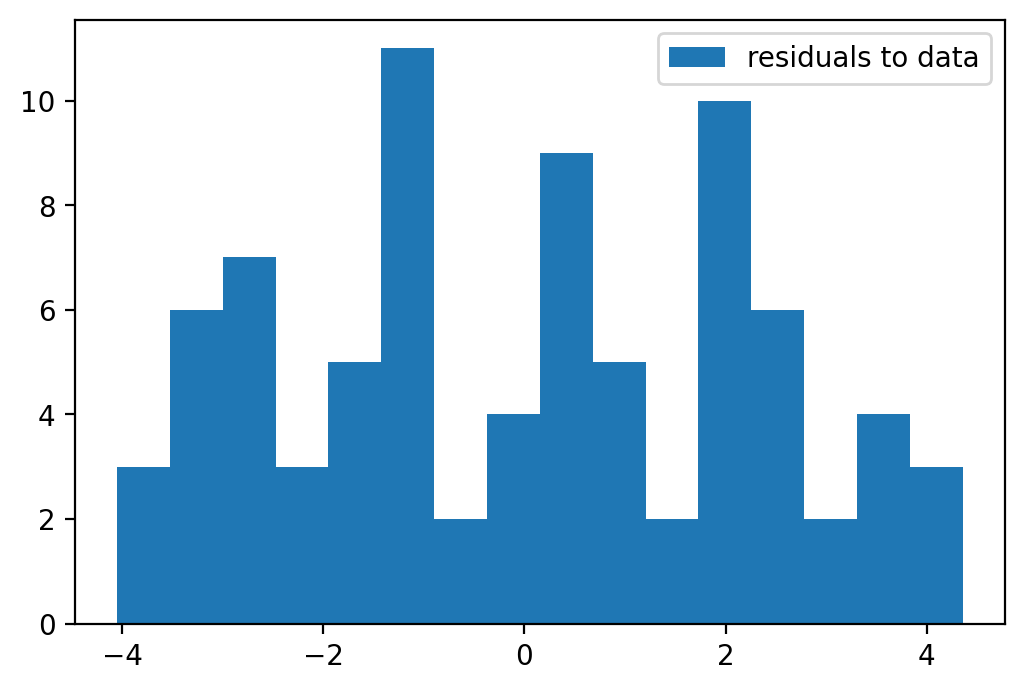

In [90]:
plt.hist(df['residuals'], 16, label = 'residuals to data')
#plt.hist(df['residuals_avg'], label = 'residuals to avg')

plt.legend()

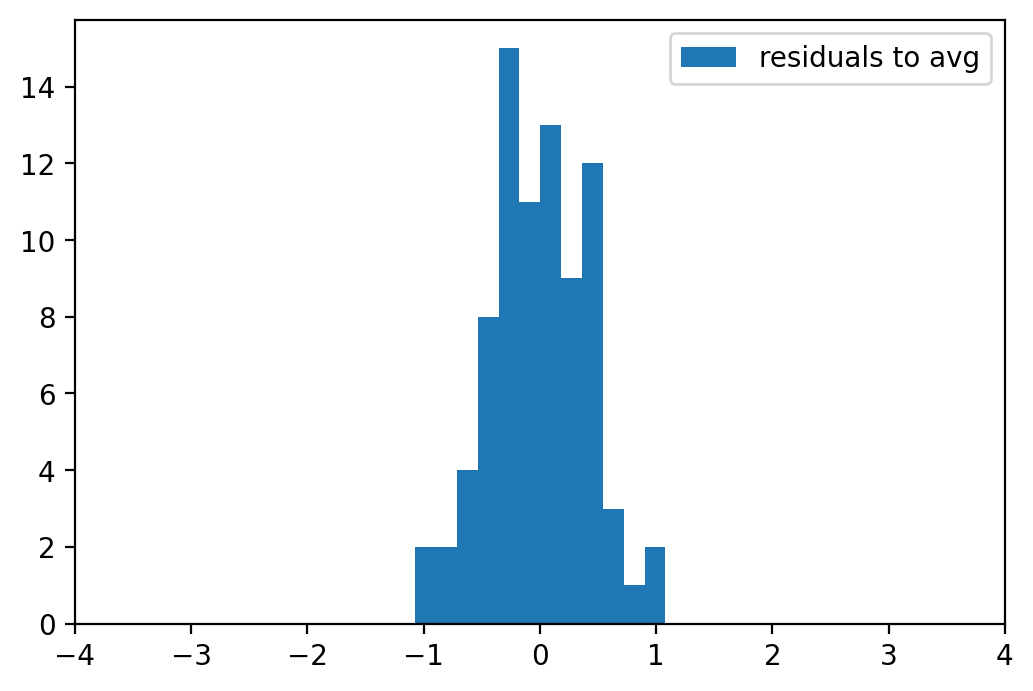

In [91]:
#plt.hist(df['residuals'], label = 'residuals to data')
plt.hist(df['residuals_avg'],12, label = 'residuals to avg')
plt.xlim(-4, 4)
plt.legend()

In [92]:
df['residuals'].std()

2.284338668817118

In [93]:
df['residuals_avg'].std()

0.42855354238687027

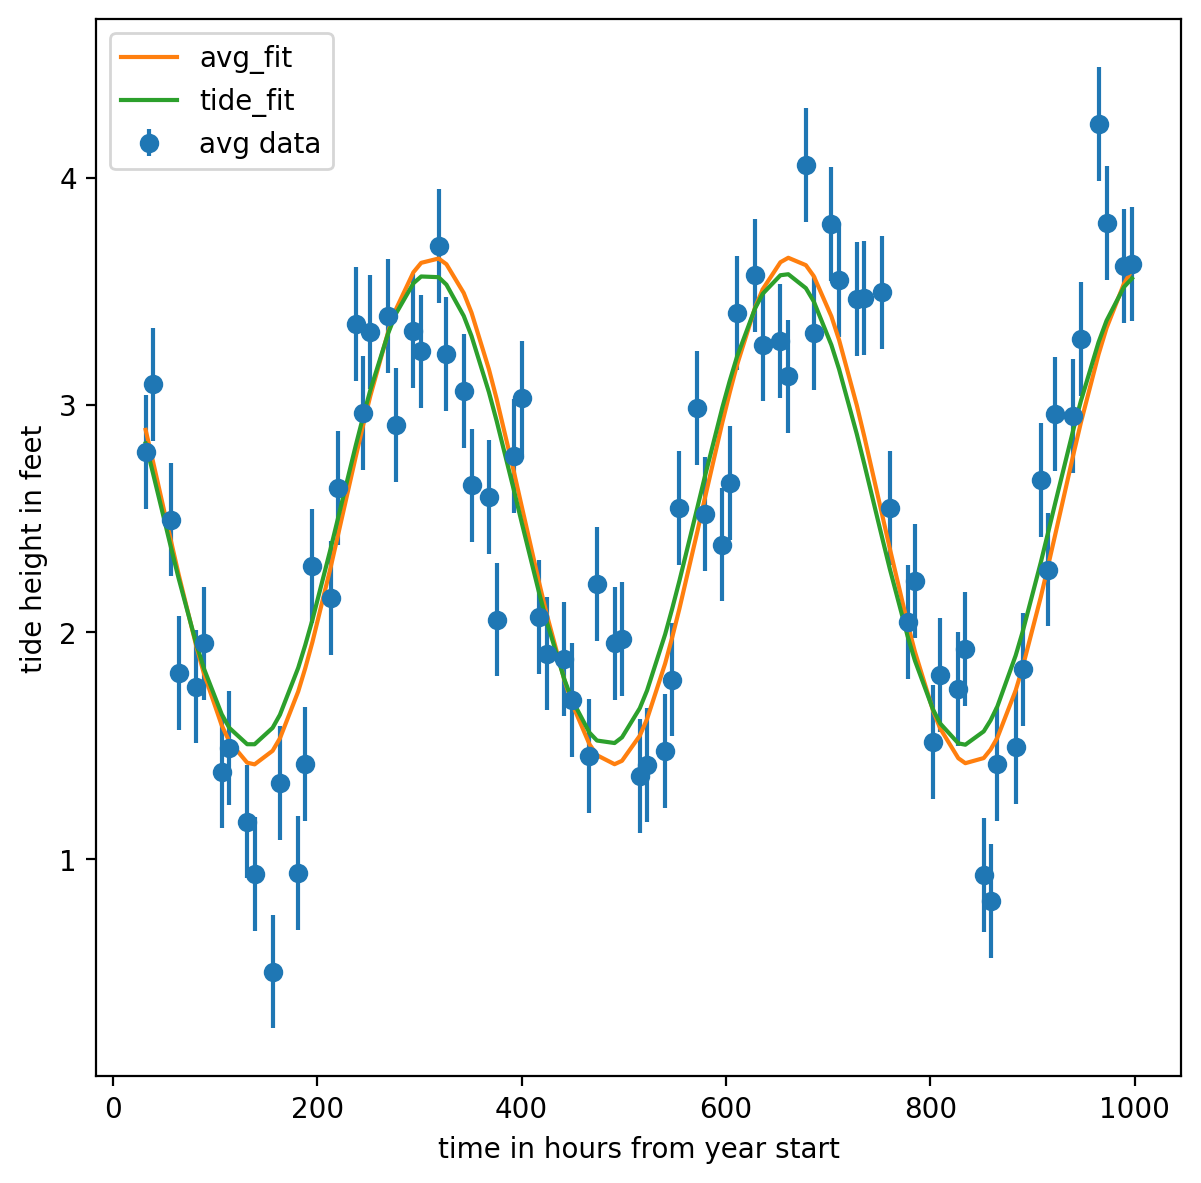

In [94]:
f = plt.figure(figsize = (7,7))
plt.errorbar(x,df['tideavg'], yerr = y_error, fmt = 'o', label = 'avg data')
plt.plot(x,avg_fit, label = 'avg_fit')
plt.plot(x,tide_fit, label = 'tide_fit')
plt.xlabel('time in hours from year start')
plt.ylabel('tide height in feet')
plt.legend()

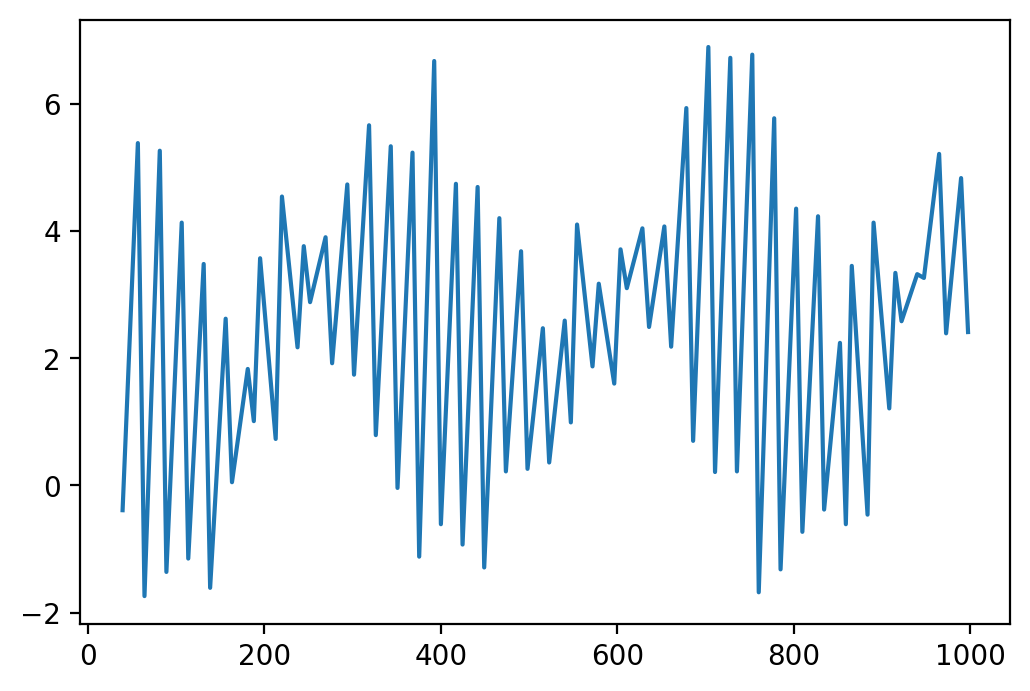

In [95]:
plt.plot(x[1:],y[1:])

## Attempt using two sine waves added to each other

In [96]:
##now lets try and make it have a sinusoidal wave as an amplitude to get intra day variation

def ef_line(x,a,b,c,d, alpha, beta, gamma):
  return alpha*np.sin(beta*x + gamma) + (a * np.sin(b*x + c)) + d

params, paramscov = optimize.curve_fit(ef_line, x, df['tideavg'], sigma=y_error, p0 = [1.4,.02,-.1,2.1,-2,1,.1] )

a_fit = params[0]
b_fit = params[1]
c_fit = params[2]
d_fit = params[3]
alpha_fit = params[4]
beta_fit = params[5]
gamma_fit = params[6]

print(a_fit, b_fit, c_fit, d_fit,alpha_fit, beta_fit, gamma_fit)
dd_fit = (alpha_fit*np.sin(beta_fit*x + gamma_fit)) + (a_fit * np.sin(b_fit*x + c_fit)) + d_fit
#dd_fit =  -2*(np.sin(1*x + 1)) + 1.12* np.sin(.017 * x+2.22) + 2.5

1.1956770499973381 0.017618135597962 2.435653076925225 2.5633419576706973 -0.2126249463135276 0.9969873061848501 3.0899012772497594


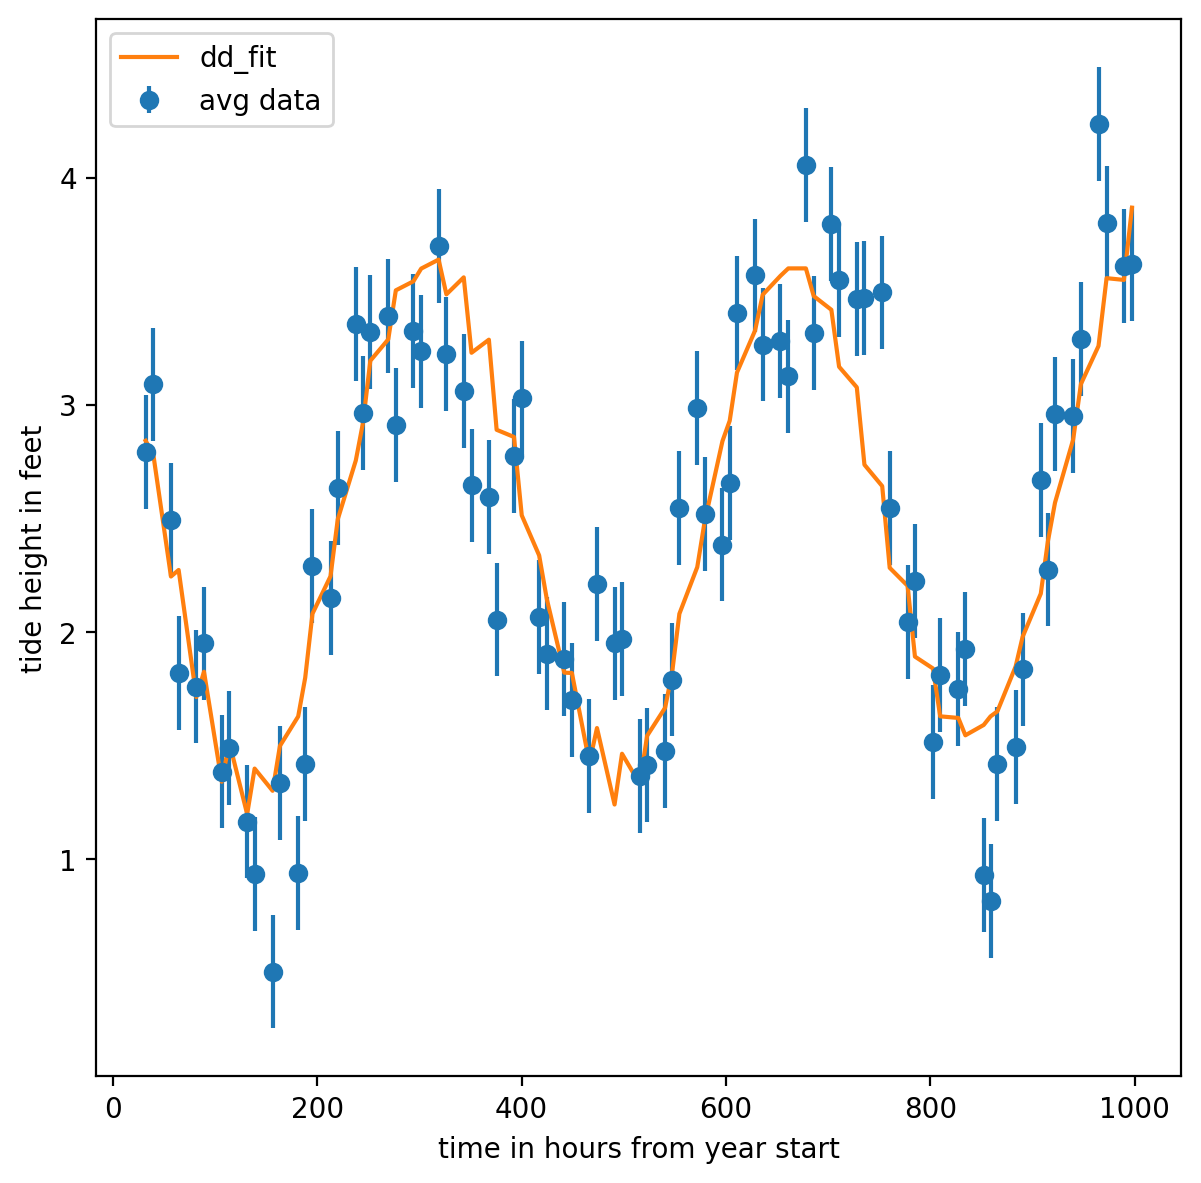

In [97]:
f = plt.figure(figsize = (7,7))
plt.errorbar(x,df['tideavg'], yerr = y_error, fmt = 'o', label = 'avg data')
plt.plot(x,dd_fit, label = 'dd_fit')
#plt.plot(x,tide_fit, label = 'tide_fit')
plt.xlabel('time in hours from year start')
plt.ylabel('tide height in feet')
plt.legend()

## New objective function test fit
I think something of the form $amp*sin(\alpha x + \beta) * sin(y) + sin(x) $ might work well

In [98]:
##now lets try and make it have a sinusoidal wave as an amplitude to get intra day variation

def three_sine(x, int_amp, int_freq1, int_offset1, int_freq2, int_offset2, ext_amp,ext_freq, ext_offset, vert_offset):
  return  (int_amp * np.sin(int_freq1*x + int_offset1) * np.sin(int_freq2*x + int_offset2)) + (ext_amp * np.sin(ext_freq*x + ext_offset)) + vert_offset * x
# (sin(freq24hrs * x + phase2)) * (sin(longfreq * x + phase)) + voff-mean
#
params, paramscov = optimize.curve_fit(three_sine, x, df['tide'], p0=[2,.4,1,16,1,1,1,2.22,2.5]  )#sigma=y_error, p0=[2,.4,0,1,0,1,.01,2.22,2.5]

int_amp_fit = params[0]
int_freq1_fit = params[1]
int_offset1_fit = params[2]
int_freq2_fit = params[3]
int_offset2_fit = params[4]
ext_amp_fit = params[5]
ext_freq_fit = params[6]
ext_offset_fit = params[7]
vert_offset_fit = params[8]

print(params)
tsine_fit = (int_amp_fit * np.sin(int_freq1_fit*x + int_offset1_fit) * np.sin(int_freq2_fit*x + int_offset2_fit)) + (ext_amp_fit * np.sin(ext_freq_fit*x + ext_offset_fit)) + vert_offset_fit * x


[2.22132237e+00 3.97151502e-01 5.48319066e+00 1.59973099e+01
 8.33273536e-01 1.43031675e+00 1.00503971e+00 1.44500361e+00
 4.64749440e-03]


In [99]:
#tsine_fit =   (1* np.sin(1*x + 1) * np.sin(1*x + 1)) + 1* np.sin(5* x+2.22) +.5

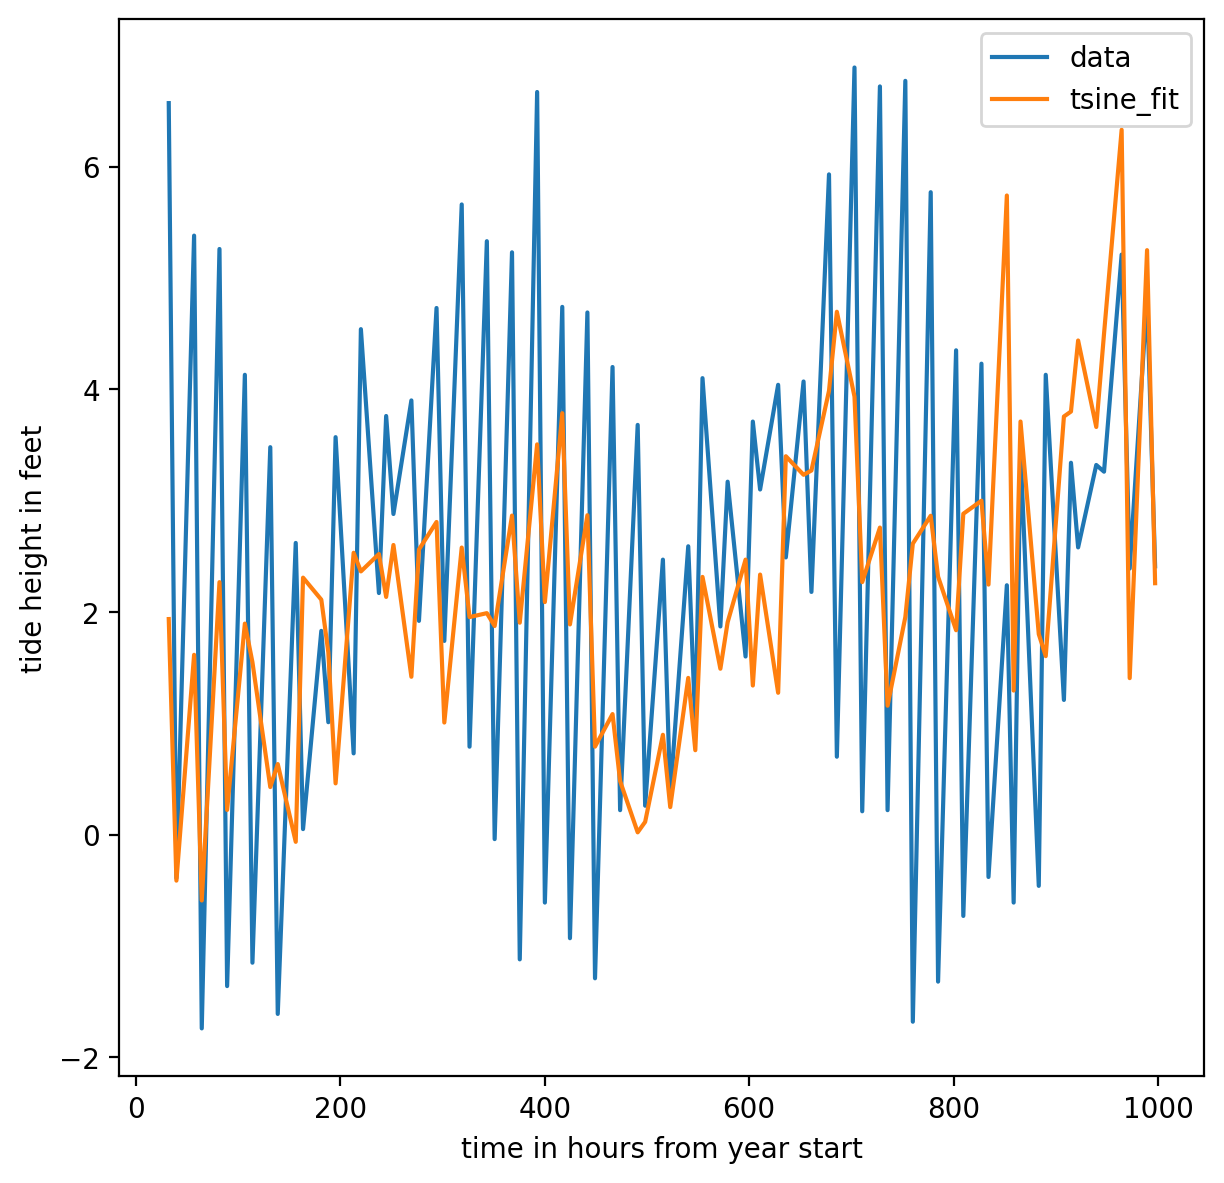

In [100]:
f = plt.figure(figsize = (7,7))
#plt.errorbar(x,df['tideavg'], yerr = y_error, fmt = 'o', label = 'avg data')
plt.plot(x,df['tide'], label = 'data')
plt.plot(x,tsine_fit, label = 'tsine_fit')
#plt.plot(x,tide_fit, label = 'tide_fit')
plt.xlabel('time in hours from year start')
plt.ylabel('tide height in feet')
plt.legend()

In [101]:
#constant * sin(x)

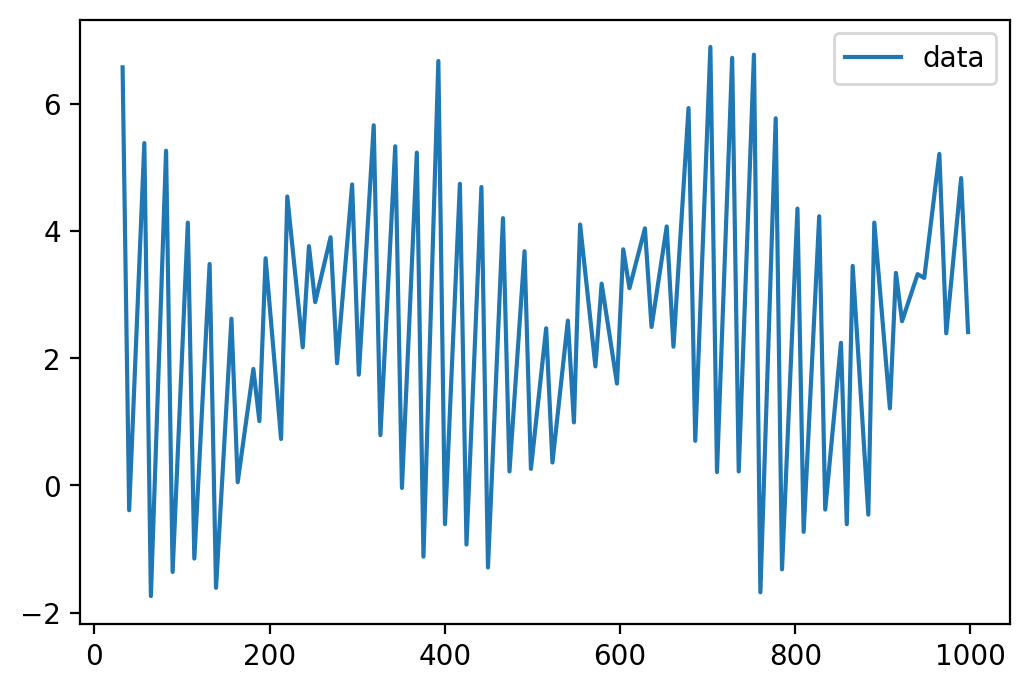

In [102]:
plt.plot(x,df['tide'], label = 'data')
plt.legend()